# Introduction

Welcome to my notebook! In this notebook, I explore [**FT-Transformer**](https://arxiv.org/pdf/2106.11959v2.pdf).

FT-Transformer is a Deep NN model using transfomer for tabular data. FT-Transformer is modified from TabTransformer. In FT-Transformer, transformers are used for extracting contextual information from both categorical and numerical data.

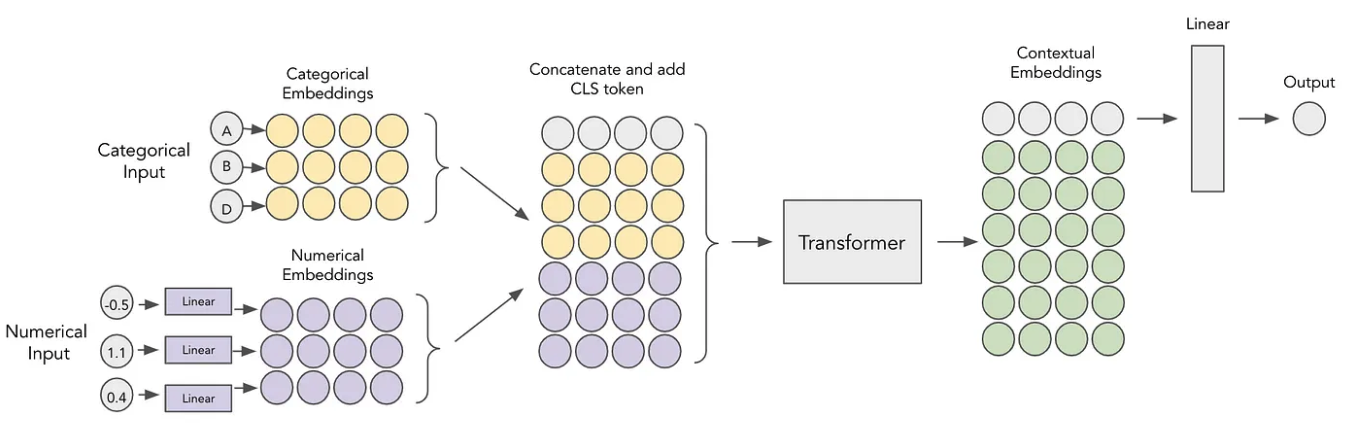
([Image by author](https://arxiv.org/pdf/2106.11959v2.pdf))
I apply FT-Transformer to Gemstone Price Prediction dataset. I use `tabtransfomertf` library to use FTTransformer.

# Import libraries

In [1]:
!pip install tabtransformertf
!pip install tensorflow-addons
from IPython.display import clear_output
clear_output()

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tabtransformertf.utils.preprocessing import df_to_dataset, build_categorical_prep
from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-05-13 14:33:10.788935: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 14:33:10.793372: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-13 14:33:10.852302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 14:33:13.925557: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mattyshen/anaconda3/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life i

ModuleNotFoundError: No module named 'keras.src.engine'

# Read Data

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e8/test.csv')

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


# Preprocessing

In [5]:
CATEGORICAL_FEATURES = ['cut', 'color', 'clarity']
NUMERIC_FEATURES = ['carat', 'depth', 'table', 'x', 'y', 'z']
FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES
TARGET_FEATURE = 'price'

In [6]:
sc = StandardScaler()
sc.fit(train_df[NUMERIC_FEATURES])
train_df[NUMERIC_FEATURES]= sc.transform(train_df[NUMERIC_FEATURES])
train_df

,id,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.576255,Premium,F,VS2,0.350768,0.402496,1.401353,1.460456,1.474414,13619
1,1,2.678513,Very Good,J,SI2,0.165874,0.402496,2.113437,2.177120,2.200187,13387
2,2,-0.196003,Ideal,G,VS1,-0.573702,-0.118652,-0.022816,0.008986,-0.049710,2772
3,3,-1.017293,Ideal,G,VS1,-0.203914,-0.639801,-1.203614,-1.188477,-1.196432,666
4,4,1.965288,Premium,G,VS2,0.720555,0.923644,1.743874,1.714463,1.793754,14453
...,...,...,...,...,...,...,...,...,...,...,...
193568,193568,-1.038906,Ideal,D,VVS2,-0.666149,-0.639801,-1.230655,-1.206620,-1.254494,1130
193569,193569,-0.196003,Premium,G,VVS2,-1.405724,0.402496,0.031267,0.045273,-0.093257,2874
193570,193570,-0.131164,Very Good,F,SI1,1.182790,-0.118652,0.004226,0.027129,0.124475,3036
193571,193571,-0.974067,Very Good,D,SI1,0.997896,-1.160949,-1.140517,-1.115903,-1.051277,681


In [7]:
train_data, val_data = train_test_split(train_df, test_size=0.2, shuffle=True, random_state=8)

In [8]:
# Transform to TF dataset
train_dataset = df_to_dataset(train_data[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=True, batch_size=1024)
val_dataset = df_to_dataset(val_data[FEATURES + [TARGET_FEATURE]], TARGET_FEATURE, shuffle=False, batch_size=1024)

/opt/conda/lib/python3.7/site-packages/tabtransformertf/utils/preprocessing.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [9]:
category_prep_layers = build_categorical_prep(train_data, CATEGORICAL_FEATURES)

100%|██████████| 3/3 [00:00<00:00, 39.23it/s]


# Build and train model

## FT-Transformer
The difference between TabTransformer and FT-Transformer is whether transfomer is used for numeric data. In FT-Transformer, numeric data are sent to Numerical Embeddings to process in Transformer. Numerical Embeddings can improve the performance of various improve model.([Reference](https://arxiv.org/abs/2203.05556))

(If you want to know more, See:[Transformers for Tabular Data (Part 2): Linear Numerical Embeddings](https://towardsdatascience.com/improving-tabtransformer-part-1-linear-numerical-embeddings-dbc3be3b5bb5))

In [10]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features=NUMERIC_FEATURES,  # list of numeric features
    categorical_features=CATEGORICAL_FEATURES,  # list of numeric features
    numerical_data=train_df[NUMERIC_FEATURES].values,
    categorical_data=train_df[CATEGORICAL_FEATURES].values,
    y = None,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass the encoder to the model
ft_model = FTTransformer(
    encoder=ft_linear_encoder,  # Encoder from above
    out_dim=1,  # Number of outputs in final layer
    out_activation='relu',  # Activation function for final layer
)

In [11]:
epochs = 1000
lr = 0.001
weight_decay = 0.0001
optimizer = tfa.optimizers.AdamW(
        learning_rate=lr, weight_decay=weight_decay
    )

ft_model.compile(
    optimizer = optimizer,
    loss = tf.keras.losses.MeanSquaredError(),
    metrics= [tf.keras.metrics.RootMeanSquaredError()],
)


early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10)

history = ft_model.fit(
    train_dataset, 
    epochs=epochs, 
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/1000
152/152 [==============================] - 53s 297ms/step - loss: 63956352.0000 - importances_loss: 32049802.0000 - output_loss: 31906560.0000 - importances_root_mean_squared_error: 5661.2554 - output_root_mean_squared_error: 5648.5894 - val_loss: 63558020.0000 - val_importances_loss: 31948260.0000 - val_output_loss: 31609758.0000 - val_importances_root_mean_squared_error: 5652.2793 - val_output_root_mean_squared_error: 5622.2554
Epoch 2/1000
152/152 [==============================] - 45s 290ms/step - loss: 63309768.0000 - importances_loss: 32049798.0000 - output_loss: 31259970.0000 - importances_root_mean_squared_error: 5661.2554 - output_root_mean_squared_error: 5591.0615 - val_loss: 62473680.0000 - val_importances_loss: 31948260.0000 - val_output_loss: 30525422.0000 - val_importances_root_mean_squared_error: 5652.2793 - val_output_root_mean_squared_error: 5524.9814
Epoch 3/1000
152/152 [==============================] - 45s 292ms/step - loss: 61668652.0000 - importances

In [12]:
history = history.history

In [13]:
fontsize_title = 25
fontsize_axis = 15

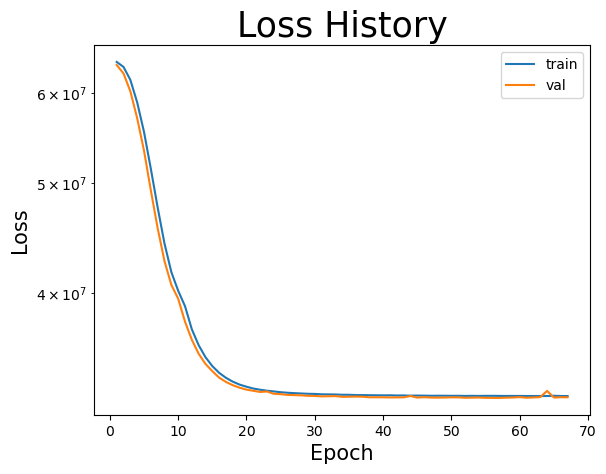

In [14]:
plt.plot(range(1, len(history['loss'])+1), history['loss'], label='train')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='val')
plt.yscale('log')
plt.title('Loss History', fontsize=fontsize_title)
plt.xlabel('Epoch', fontsize=fontsize_axis)
plt.ylabel('Loss', fontsize=fontsize_axis)
plt.legend()
plt.show()

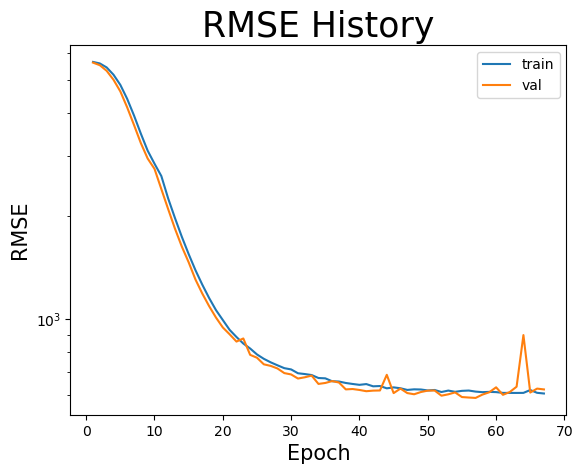

In [15]:
plt.plot(range(1, len(history['output_root_mean_squared_error'])+1), history['output_root_mean_squared_error'], label='train')
plt.plot(range(1, len(history['val_output_root_mean_squared_error'])+1), history['val_output_root_mean_squared_error'], label='val')
plt.yscale('log')
plt.title('RMSE History', fontsize=fontsize_title)
plt.xlabel('Epoch', fontsize=fontsize_axis)
plt.ylabel('RMSE', fontsize=fontsize_axis)
plt.legend()
plt.show()

38/38 [==============================] - 4s 93ms/step


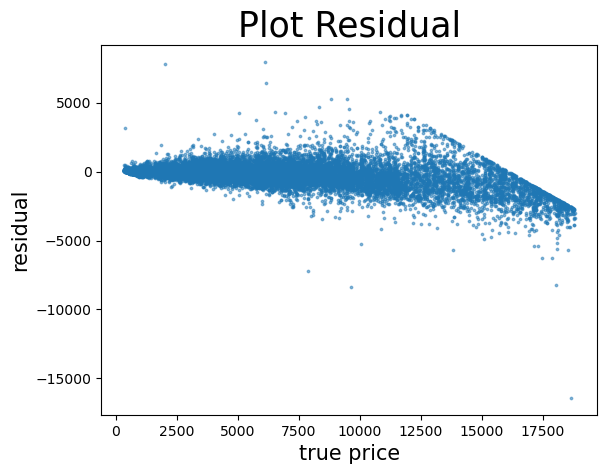

In [16]:
y_pred = ft_model.predict(val_dataset)['output'].reshape(-1)
y_true = val_data['price'].values
residual = y_pred - y_true
plt.scatter(y_true, residual, s=3, alpha=0.5)
plt.title('Plot Residual', fontsize=fontsize_title)
plt.xlabel('true price', fontsize=fontsize_axis)
plt.ylabel('residual', fontsize=fontsize_axis)
plt.show()

# Predict

In [17]:
test_df[NUMERIC_FEATURES]= sc.transform(test_df[NUMERIC_FEATURES])

In [18]:
test_dataset = df_to_dataset(test_df, shuffle=False)

/opt/conda/lib/python3.7/site-packages/tabtransformertf/utils/preprocessing.py:27: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  dataset[key] = value[:, tf.newaxis]


In [19]:
y_pred = ft_model.predict(test_dataset)['output'].reshape(-1)

253/253 [==============================] - 13s 48ms/step


# Submit

In [20]:
submission_df = pd.read_csv('/kaggle/input/playground-series-s3e8/sample_submission.csv')
submission_df['price'] = y_pred
submission_df.to_csv('submission.csv', index=False)

Please give me feedbacks for improving score.

Thank you!